In [15]:
import numpy as np

class GridWorld:
    def __init__(self, size=5, start=(0, 0), goal=(4, 4)):
        self.size = size
        self.state = start
        self.start = start
        self.goal = goal
        self.actions = ['up', 'down', 'left', 'right']
        self.action_space = len(self.actions)

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action):
        x, y = self.state
        if action == 0:  # up
            x = max(0, x - 1)
        elif action == 1:  # down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # left
            y = max(0, y - 1)
        elif action == 3:  # right
            y = min(self.size - 1, y + 1)
        self.state = (x, y)
        reward = 1 if self.state == self.goal else -1
        done = self.state == self.goal
        return self.state, reward, done

    def render(self):
        grid = np.zeros((self.size, self.size))
        grid[self.state] = 1
        grid[self.goal] = 2
        print(grid)


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# Hyperparameters
learning_rate = 0.01
gamma = 0.99
epsilon = 0.1
episodes = 500
grid_size = 5
input_dim = 2  # State is a 2D coordinate
output_dim = 4  # 4 possible actions

# Initialize environment, Q-network, and optimizer
env = GridWorld(size=grid_size)
q_net = QNetwork(input_dim, output_dim)
optimizer = optim.Adam(q_net.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Training loop
for episode in range(episodes):
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32)

    done = False
    while not done:
        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            action = np.random.choice(output_dim)
        else:
            with torch.no_grad():
                q_values = q_net(state)
                action = torch.argmax(q_values).item()

        next_state, reward, done = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32)
        reward = torch.tensor(reward, dtype=torch.float32)

        # Q-learning update
        with torch.no_grad():
            target = reward + gamma * torch.max(q_net(next_state)) * (1 - done)
        q_values = q_net(state)
        loss = criterion(q_values[action], target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = next_state

    if episode % 100 == 0:
        print(f"Episode {episode}, Loss: {loss.item()}")


Episode 0, Loss: 5153.1689453125
Episode 100, Loss: 0.464173823595047
Episode 200, Loss: 0.0029450030997395515
Episode 300, Loss: 0.001206045737490058
Episode 400, Loss: 0.000994082191027701


In [17]:
state = env.reset()
done = False
env.render()

while not done:
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32)
        q_values = q_net(state_tensor)
        action = torch.argmax(q_values).item()
    
    state, reward, done = env.step(action)
    env.render()


[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2.]]
[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2.]]
[[0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 2.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 2.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2.]]


Policy Grid:
[['↓' '↓' '↓' '↓' '↓']
 ['→' '↓' '↓' '↓' '↓']
 ['→' '→' '→' '↓' '↓']
 ['→' '→' '→' '→' '↓']
 ['→' '→' '→' '→' '↓']]


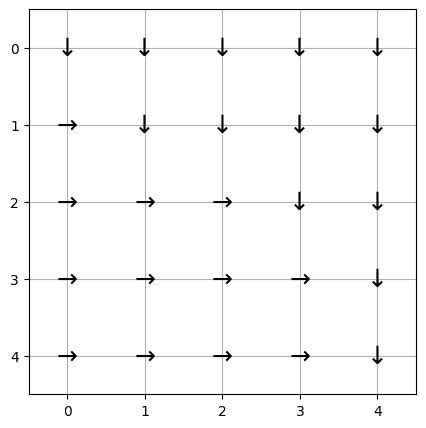

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# 方策を視覚化するための関数
def visualize_policy(q_net, grid_size):
    policy_grid = np.zeros((grid_size, grid_size), dtype=str)

    for i in range(grid_size):
        for j in range(grid_size):
            state = torch.tensor([i, j], dtype=torch.float32)
            with torch.no_grad():
                q_values = q_net(state)
                action = torch.argmax(q_values).item()
            
            if action == 0:
                policy_grid[i, j] = '↑'
            elif action == 1:
                policy_grid[i, j] = '↓'
            elif action == 2:
                policy_grid[i, j] = '←'
            elif action == 3:
                policy_grid[i, j] = '→'
    
    return policy_grid

# 方策の視覚化
policy = visualize_policy(q_net, grid_size)
print("Policy Grid:")
print(policy)

# 視覚化を行う
plt.figure(figsize=(grid_size, grid_size))
for i in range(grid_size):
    for j in range(grid_size):
        plt.text(j, i, policy[i, j], ha='center', va='center', fontsize=18)

plt.xlim(-0.5, grid_size - 0.5)
plt.ylim(-0.5, grid_size - 0.5)
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()
